# ROC AUC Plot for Carpet class in mvtec

In [1]:
# make a cell print all the outputs instead of just the last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Evaluation

### Set up

In [2]:
%cd "C:\Users\Public\Documents\DIMA\fcdd\python\analyse"

c:\Users\Public\Documents\DIMA\fcdd\python\analyse


In [3]:
from pathlib import Path

FIGS_DIR = Path(".") / "figs"
FIGS_DIR.mkdir(exist_ok=True)

DATA_DIR = Path(".") / "data" # est-ce le bon dossier ?
DATA_DIR.mkdir(exist_ok=True)

SNAPSHOTS_DIR = Path("../../data")
assert SNAPSHOTS_DIR.exists()

MVTECAD_DIR = Path("../../data/datasets/mvtec") # est-ce le bon dossier ?
assert MVTECAD_DIR.exists()

RECORDS_FPATH = DATA_DIR / "snapshot.pt"

HEATMAPS_DIR = Path(".") / "data" / "generated_heatmaps" / "carpet_train_test"

In [4]:
%matplotlib inline

In [5]:
import numpy as np

## Load datasets

### Load images

In [6]:
IMAGES_GLOB = "*.png"

imgs = []

# We only want the "carpet" class
# If you want all the classes, use a for loop (see notebook 010-generate-predictions-from-snapshots)
classdir = MVTECAD_DIR / "carpet"


print(f"{classdir.name=}")

traindir = classdir / "train"
testdir = classdir / "test"

print(f"{testdir.name=}")

for typedir in testdir.glob("*"):
    
    if not typedir.is_dir():
        continue
    
    print(f"{typedir.name=}")
    
    img_paths = list(typedir.glob(IMAGES_GLOB))
    
    if len(img_paths) == 0:
        print("empty dir")
        continue  
    
    print(f"{len(img_paths)=}")      
    
    for imgpath in img_paths:
        imgs.append({
            "imgpath": imgpath.resolve(),
            "class": classdir.name,
            "type": typedir.name,
            "set": "test",
            "imgidx": int(imgpath.stem),
        })

img_paths = list((traindir / "good").glob(IMAGES_GLOB))

if len(img_paths) == 0:
    print("empty dir")

else:
    for imgpath in img_paths:
        imgs.append({
            "imgpath": imgpath.resolve(),
            "class": classdir.name,
            "type": "good",
            "set": "train",
            "imgidx": int(imgpath.stem),
        })    

print(30 * "-")

print(f"{len(imgs)=}")

classdir.name='carpet'
testdir.name='test'
typedir.name='color'
len(img_paths)=19
typedir.name='cut'
len(img_paths)=17
typedir.name='good'
len(img_paths)=28
typedir.name='hole'
len(img_paths)=17
typedir.name='metal_contamination'
len(img_paths)=17
typedir.name='thread'
len(img_paths)=19
------------------------------
len(imgs)=397


In [7]:
import pandas as pd
imgs = pd.DataFrame.from_records(data=imgs).set_index(["class", "set", "type", "imgidx"])
imgs

imgpath
class  set   type  imgidx                                                   
carpet test  color 0       C:\Users\Public\Documents\DIMA\fcdd\data\datas...
                   1       C:\Users\Public\Documents\DIMA\fcdd\data\datas...
                   2       C:\Users\Public\Documents\DIMA\fcdd\data\datas...
                   3       C:\Users\Public\Documents\DIMA\fcdd\data\datas...
                   4       C:\Users\Public\Documents\DIMA\fcdd\data\datas...
...                                                                      ...
       train good  275     C:\Users\Public\Documents\DIMA\fcdd\data\datas...
                   276     C:\Users\Public\Documents\DIMA\fcdd\data\datas...
                   277     C:\Users\Public\Documents\DIMA\fcdd\data\datas...
                   278     C:\Users\Public\Documents\DIMA\fcdd\data\datas...
                   279     C:\Users\Public\Documents\DIMA\fcdd\data\datas...

[397 rows x 1 columns]

In [8]:
from matplotlib import image
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

images_loaded = []

for path in list(imgs["imgpath"].to_numpy()):
    img = image.imread(path)
    img_resized = resize(img, (224, 224),
                       anti_aliasing=True)
    images_loaded.append(img_resized)

images_loaded = np.array(images_loaded)
images_loaded.shape

(397, 224, 224, 3)

In [9]:
images_loaded = np.reshape(images_loaded, (397, 3, 224, 224))
images_loaded.shape

(397, 3, 224, 224)

### Load heatmaps

In [10]:
IMAGES_GLOB = "*.png"

heatmaps_loaded = []

heatmaps_dir = HEATMAPS_DIR

for hm_path in heatmaps_dir.glob("*"):
    hm = image.imread(hm_path)
    hm_resized = resize(hm, (224, 224),
                       anti_aliasing=True)
    heatmaps_loaded.append(hm_resized)

heatmaps_loaded = np.array(heatmaps_loaded)
heatmaps_loaded.shape
    

(397, 224, 224, 4)

In [11]:
# We reduce to only one dimension per pixel:

heatmaps_reduced_loaded = []

for hm in heatmaps_loaded:
    # hm.shape
    heatmaps_reduced_loaded.append(np.mean(hm, 2))

heatmaps_reduced_loaded = np.array(heatmaps_reduced_loaded)
heatmaps_reduced_loaded.shape

(397, 224, 224)

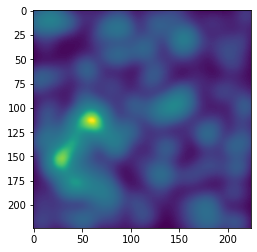

In [41]:
# im_test1 = heatmaps_loaded[0]
# im_test2 = heatmaps_reduced_loaded[0]
# import matplotlib.pyplot as plt
# plt.imshow(im_test1)
# plt.imshow(im_test2)

### Pair images and heatmaps

In [12]:
import torch

In [13]:
heatmaps_reduced_loaded = torch.from_numpy(heatmaps_reduced_loaded)
heatmaps_reduced_loaded = torch.squeeze(heatmaps_reduced_loaded)
heatmaps_reduced_loaded = torch.unsqueeze(heatmaps_reduced_loaded, 1)
heatmaps_reduced_loaded.shape

torch.Size([397, 1, 224, 224])

In [14]:
images_loaded = torch.from_numpy(images_loaded)
images_loaded.shape

torch.Size([397, 3, 224, 224])

In [15]:
train_images = torch.cat((images_loaded, heatmaps_reduced_loaded), 1)
train_images.shape

torch.Size([397, 4, 224, 224])

## Get labels

### Load masks of test set

In [16]:
MASKS_GLOB = "*.png"

masks_test = []

# We only want the "carpet" class
# If you want all the classes, use a for loop (see notebook 010-generate-predictions-from-snapshots)

classdir = MVTECAD_DIR / "carpet"

print(f"{classdir.name=}")

groundtruthdir = classdir / "ground_truth"

print(f"{groundtruthdir.name=}")

for typedir in groundtruthdir.glob("*"):
    
    if not typedir.is_dir():
        continue
    
    print(f"{typedir.name=}")
    
    masks_paths = list(typedir.glob(MASKS_GLOB))
    
    if len(masks_paths) == 0:
        print("empty dir")
        continue
    
    print(f"{len(masks_paths)=}")
    
    for maskpath in masks_paths:
        masks_test.append({
            "mask_path": maskpath.resolve(),
            "class": classdir.name,
            "type": typedir.name,
            "set": "ground_truth",
            "mask_idx": int(maskpath.stem[:3]),
        })
        

print(30 * "-")

print(f"{len(masks_test)=}")

classdir.name='carpet'
groundtruthdir.name='ground_truth'
typedir.name='color'
len(masks_paths)=19
typedir.name='cut'
len(masks_paths)=17
typedir.name='hole'
len(masks_paths)=17
typedir.name='metal_contamination'
len(masks_paths)=17
typedir.name='thread'
len(masks_paths)=19
------------------------------
len(masks_test)=89


In [18]:
import pandas as pd
df_masks_test = pd.DataFrame.from_records(data=masks_test).set_index(["class", "type", "set", "mask_idx"])
df_masks_test

mask_path
class  type   set          mask_idx                                                   
carpet color  ground_truth 0         C:\Users\Public\Documents\DIMA\fcdd\data\datas...
                           1         C:\Users\Public\Documents\DIMA\fcdd\data\datas...
                           2         C:\Users\Public\Documents\DIMA\fcdd\data\datas...
                           3         C:\Users\Public\Documents\DIMA\fcdd\data\datas...
                           4         C:\Users\Public\Documents\DIMA\fcdd\data\datas...
...                                                                                ...
       thread ground_truth 14        C:\Users\Public\Documents\DIMA\fcdd\data\datas...
                           15        C:\Users\Public\Documents\DIMA\fcdd\data\datas...
                           16        C:\Users\Public\Documents\DIMA\fcdd\data\datas...
                           17        C:\Users\Public\Documents\DIMA\fcdd\data\datas...
                           18        C:\Users\Public\Documents\DIMA\fcdd\data\datas...

[89 rows x 1 columns]

#### Complete the masks of the test set

In [19]:
from matplotlib import image
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

masks_test_anormal = []

for path in list(df_masks_test["mask_path"].to_numpy()):
    img = image.imread(path)
    img_resized = resize(img, (224, 224),
                       anti_aliasing=True)
    masks_test_anormal.append(img_resized)

In [20]:
masks_test_normal = []
for i in range(28):
    mask = np.zeros((224,224))
    masks_test_normal.append(mask)

In [21]:
all_masks_test = np.array(masks_test_anormal[:36]+masks_test_normal+masks_test_anormal[36:])
all_masks_test.shape

(117, 224, 224)

### Create the masks of the train set

In [22]:
masks_train = []

img_nb = 280

for i in range(img_nb):
    mask = np.zeros((224,224))
    masks_train.append(mask)

masks_train = np.array(masks_train)
masks_train.shape

(280, 224, 224)

### Combine the two sets of masks

In [23]:
masks = np.concatenate((all_masks_test, masks_train))

### From the masks get the label

In [56]:
labels = np.any(masks, axis=(1,2)).astype(float)
labels.shape
print(labels)

(397,)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [57]:
# # Provisoire
# labels = [1. for i in range(36)] + [0. for i in range(28)] + [1. for i in range(53)] + [0. for i in range(280)]
# labels = np.array(labels)

In [58]:
labels = torch.from_numpy(labels)
labels.shape

torch.Size([397])

## Learning of classification

### Create sets

In [59]:
labels = labels.type(torch.LongTensor)

In [60]:
import sklearn.model_selection as sk

X_train, X_test, y_train, y_test = sk.train_test_split(train_images, labels, test_size=0.33, random_state = 42)
X_train.shape
y_train.shape
X_test.shape
y_test.shape

torch.Size([265, 4, 224, 224])

torch.Size([265])

torch.Size([132, 4, 224, 224])

torch.Size([132])

### Create a CNN

In [61]:
import torch.nn as nn
import torch.nn.functional as F

In [62]:
in_size = 4
hid1_size = 8
hid2_size = 16
hid3_size = 32
# hid4_size = 16
out_size = 2
k_conv_size = 3

In [63]:
class ConvNet(nn.Module):

    def __init__(self):

        super(ConvNet, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_size, hid1_size, k_conv_size),
            nn.BatchNorm2d(hid1_size),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(hid1_size, hid1_size, kernel_size=2, stride=2, padding=0)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(hid1_size, hid2_size, k_conv_size),
            nn.BatchNorm2d(hid2_size),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(hid2_size, hid2_size, kernel_size=2, stride=2, padding=0)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(hid2_size, hid3_size, k_conv_size),
            nn.BatchNorm2d(hid3_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        # self.layer4 = nn.Sequential(
        #     nn.Conv2d(hid3_size, hid4_size, 5),
        #     nn.BatchNorm2d(hid4_size),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=12),
        # )

        self.fc = nn.Linear(21632, out_size)

    def forward(self, x):
        out = self.layer1(x)
        print(out.shape)

        out = self.layer2(out)
        print(out.shape)

        out = self.layer3(out)
        print(out.shape)

        # out = self.layer4(out)
        # print(out.shape)

        out = torch.reshape(out, (out.size(0), 21632))
        print(out.shape)

        out = self.fc(out)
        print(out.shape)

        return out

In [64]:
model = ConvNet()

In [65]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [66]:
model.to(device)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 8, kernel_size=(2, 2), stride=(2, 2))
  )
  (layer2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(2, 2), stride=(2, 2))
  )
  (layer3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=21632, out_features=2, bias=True)
)

In [67]:
X_train = X_train.to(device)
y_train = y_train.to(device)

### Train the CNN

In [68]:
learning_rate = .001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [69]:
num_epochs = 100
loss_values = list()

In [70]:
for epoch in range(num_epochs):
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(epoch, loss.item())
    loss_values.append(loss.item())

torch.Size([265, 8, 111, 111])
torch.Size([265, 16, 54, 54])
torch.Size([265, 32, 26, 26])
torch.Size([265, 21632])
torch.Size([265, 2])
0 0.8407371640205383
torch.Size([265, 8, 111, 111])
torch.Size([265, 16, 54, 54])
torch.Size([265, 32, 26, 26])
torch.Size([265, 21632])
torch.Size([265, 2])
1 7.719083309173584
torch.Size([265, 8, 111, 111])
torch.Size([265, 16, 54, 54])
torch.Size([265, 32, 26, 26])
torch.Size([265, 21632])
torch.Size([265, 2])
2 9.3939847946167
torch.Size([265, 8, 111, 111])
torch.Size([265, 16, 54, 54])
torch.Size([265, 32, 26, 26])
torch.Size([265, 21632])
torch.Size([265, 2])
3 8.450217247009277
torch.Size([265, 8, 111, 111])
torch.Size([265, 16, 54, 54])
torch.Size([265, 32, 26, 26])
torch.Size([265, 21632])
torch.Size([265, 2])
4 6.189974784851074
torch.Size([265, 8, 111, 111])
torch.Size([265, 16, 54, 54])
torch.Size([265, 32, 26, 26])
torch.Size([265, 21632])
torch.Size([265, 2])
5 3.297335386276245
torch.Size([265, 8, 111, 111])
torch.Size([265, 16, 54, 54]

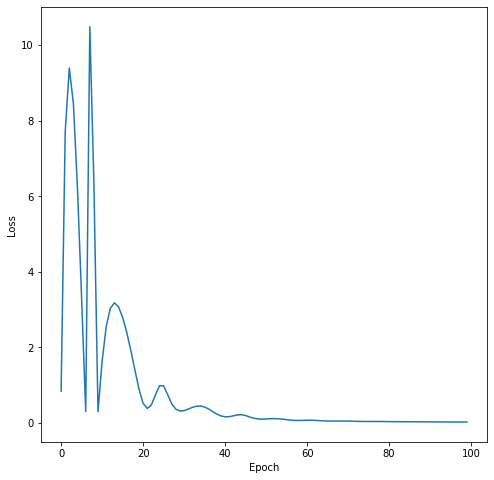

In [72]:
import matplotlib.pyplot as plt

x = range(num_epochs)
plt.figure(figsize= (8, 8));
plt.plot(x, loss_values);
plt.xlabel("Epoch");
plt.ylabel("Loss");

### Evaluate the results

In [73]:
model.eval()

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 8, kernel_size=(2, 2), stride=(2, 2))
  )
  (layer2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(2, 2), stride=(2, 2))
  )
  (layer3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=21632, out_features=2, bias=True)
)

In [74]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [75]:
with torch.no_grad():
    correct = 0
    total = 0

    CNN_outputs = model(X_test)
    _, predictions = torch.max(CNN_outputs.data, 1)

    y_test_np = y_test.cpu().numpy()
    predictions = predictions.cpu()

    print("Accuracy: ", accuracy_score(y_test_np, predictions))
    print("Precision: ", precision_score(y_test_np, predictions, average='weighted'))
    print("Recall: ", recall_score(y_test_np, predictions, average='weighted'))

torch.Size([132, 8, 111, 111])
torch.Size([132, 16, 54, 54])
torch.Size([132, 32, 26, 26])
torch.Size([132, 21632])
torch.Size([132, 2])
Accuracy:  0.7424242424242424
Precision:  0.7316287878787879
Recall:  0.7424242424242424


In [76]:
print(y_test)
print(predictions)

tensor([1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
        0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1])
